# Feature Creation for Machine Learning


Spring 2018 - Profs. Foster Provost and Josh Attenberg

Teaching Assistant: Apostolos Filippas


***

Import all of the packages we will need.

In [1]:
# Import the libraries we will be using
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style='ticks', palette='Set2')
plt.rcParams['figure.figsize'] = 10, 8

import sys
sys.path.append("..")
from ds_utils.features_pipeline_3 import pipeline_from_config

### Data
We're going to use a mail response data set from a real direct marketing campaign. Each record represents an individual who was targeted with a direct marketing offer.  The offer was a solicitation to make a charitable donation. 

The columns (features) are:

```
income       household income
Firstdate    data assoc. with the first gift by this individual
Lastdate     data associated with the most recent gift 
Amount       average amount by this individual over all periods (incl. zeros)
rfaf2        frequency code
rfaa2        donation amount code
pepstrfl     flag indicating a star donator
glast        amount of last gift
gavr         amount of average gift
```

The target variables is `class` and is equal to one if they gave in this campaign and zero otherwise.

In [2]:
# Load the data
mailing_url = "https://gist.githubusercontent.com/anonymous/5275f1f59be561ec9734c90d80d176b9/raw/f92227f9b8cdca188c1e89094804b8e46f14f30b/-"
mailing_df = pd.read_csv(mailing_url)
# Let's take a look at the data
mailing_df.head(5)

,Income,Firstdate,Lastdate,Amount,rfaf2,rfaa2,pepstrfl,glast,gavr,class
0,3,9409,9509,0.06,1,G,0,50,30.00,0
1,2,9201,9602,0.16,4,G,X,20,20.55,1
2,0,9510,9603,0.20,4,E,0,5,8.75,0
3,6,9409,9603,0.13,2,G,0,25,22.50,0
4,0,9310,9511,0.10,1,G,0,25,12.50,0


Up to now, throughout this course, we have strictly considered modeling problems where all columns are numerical, that is, real numbers. This is convenient, as the modeling libraries provided by sklearn require numerical data. More precicely, sklearn requires input in the form of numpy arrays of numbers, or some other data type that behaves in an identical fashion, such as numerical columns from a pandas data frame. 

From the short snippet of data above, we notice that, in addition to some numerical columns, there are several additional data types. The column `rfaa2` is categorical. `Income` and `rfaf2` are also categorical with the categories just represented as numbers. `pepstrfl` is binary, but rather than the 0's and 1's we're accostomed to, we have "X" and 0. 

In this lesson, we discuss **Featurization**, the transformation of raw input data from the world into a numerical format that is hopefully informative to a machine learning model. This encompases converting binary and categorical data to a numerical encoding, but also ensuring a numerical encoding is maximally informative to a machine learning model. 

## Numerical Data

Even when presented with numerical data, one may wish to "massage" it so that it is a more useful format for a machine learning system. Some models simply prefer all inputs be on a common range or of a similar distribuiton. Some models prefer binary data or data constrained to a specific range. Let's talk about some common numerical transforms. 

- _Standardization_ : we rescale our data acting as if each features is normally distributed (Gaussian with zero mean and unit variance)
- _Scaling to a range_ : we rescale our data based on the minimum and maximum value of each feature
- _Quantilization_ : we create n new feature "buckets", letting each represent a quantile of a collection of numerical values. Each individual value is represented by a 1 in the feature corresponding to that value's quantile, and 0's in all other feature buckets. 

Let's look at how we can perform some of these transforms on numerical data. First, build training and testing datasets for later modeling

In [3]:
from sklearn.model_selection import train_test_split

train_df, test_df, y_train, y_test = train_test_split(mailing_df, mailing_df["class"], train_size=0.75, test_size=0.25)

Standardization is performed by the sklearn StandardScalar

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# note the reshape
data = scaler.fit_transform(train_df["gavr"].values.reshape(-1, 1))
data[:5]

array([[ 1.17311808],
       [-0.08381327],
       [-0.55239728],
       [ 1.42450435],
       [-0.66501833]])

Compared with before:

In [5]:
train_df["gavr"].head(5)

141384    25.00
92623     12.50
140835     7.84
106472    27.50
76706      6.72
Name: gavr, dtype: float64

Alternately, we cab perform this transform using the pipeline utility. This gives some additional functionality that will we'll see later on. Here's how we perform the same transform there.

In [6]:
standardization_config = [
    {
        "field": "gavr",
        "transformers": [
            {"name": "standard_numeric"}
        ]
    }
]

pipeline = pipeline_from_config(standardization_config)
data = pipeline.fit_transform(train_df)
data[:5]

array([[ 1.17311808],
       [-0.08381327],
       [-0.55239728],
       [ 1.42450435],
       [-0.66501833]])

Scaling to range is performed by the MinMaxScalar

In [7]:
from sklearn.preprocessing import MinMaxScaler

min = 0
max = 1
scaler =  MinMaxScaler(feature_range=(min, max))

data = scaler.fit_transform(train_df["gavr"].values.reshape(-1, 1))
data[:5]

array([[0.0237504 ],
       [0.01123438],
       [0.00656841],
       [0.0262536 ],
       [0.00544697]])

Scaling to range using the features pipeline (the default min and max are 0 and 1)

In [8]:
range_config = [
    {
        "field": "gavr",
        "transformers": [
            {"name": "range_numeric"}
        ]
    }
]

pipeline = pipeline_from_config(range_config)
data = pipeline.fit_transform(train_df)
data[:5]

array([[0.0237504 ],
       [0.01123438],
       [0.00656841],
       [0.0262536 ],
       [0.00544697]])

We can also specify the range

In [9]:
range_config = [
    {
        "field": "gavr",
        "transformers": [
            {"name": "range_numeric", "config": {"min":0, "max":5}}
        ]
    }
]

pipeline = pipeline_from_config(range_config)
data = pipeline.fit_transform(train_df)
data[:5]

array([[0.118752  ],
       [0.0561719 ],
       [0.03284204],
       [0.13126802],
       [0.02723486]])

The quantile transformer doesnt have a direct analog in sklearn

In [10]:
quantile_config = [
    {
        "field": "gavr",
        "transformers": [
            {
                "name": "quantile_numeric",
                "config": {"n_quantiles": 10}
            }
        ]
    }
]

pipeline = pipeline_from_config(quantile_config)
data = pipeline.fit_transform(train_df)
data[:5]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [11]:
# performing multiple feature transforms on a column

multi_config = [
    {
        "field": "gavr",
        "transformers": [
            {"name": "standard_numeric"},
            {
                "name": "quantile_numeric",
                "config": {"n_quantiles": 10}
            }
        ]
    }
]

pipeline = pipeline_from_config(multi_config)
data = pipeline.fit_transform(train_df)
data[:5]

array([[ 1.17311808,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ],
       [-0.08381327,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-0.55239728,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 1.42450435,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ],
       [-0.66501833,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]])

In [12]:
# transforming multiple features
multi_feat_config = [
    {
        "field": "gavr",
        "transformers": [
            {"name": "standard_numeric"}
        ]
    },
    {
        "field": "glast",
        "transformers": [
            {"name": "standard_numeric"}
        ]
    }
]

pipeline = pipeline_from_config(multi_feat_config)
data = pipeline.fit_transform(mailing_df)
data[:5]

array([[ 1.64253552,  1.14898002],
       [ 0.71044279,  0.09189676],
       [-0.4534402 , -0.43664487],
       [ 0.90277939,  0.2680773 ],
       [-0.08356213,  0.2680773 ]])

## Categorical Data


From the description above, and the head of the data, we see that two of the fields are **categorical** instead of the typical **numerical** fields we have been looking at until this point. Today, one of the models we will be using is a logistic regression. From the previous classes, we have seen that logistic regression requires *all* fields to be numerical. To do this, we are going to create "dummy" variables for all the fields that are categorical.

#### Dummyize
A dummy variable is a binary variable corresponding to one value of a categorical variable.
The typical way to create dummies for a field is to create new variables for each possible category of the field. For example consider a field called color that can have the possible values "red", "blue", and "green". To dummyize color, we would create three new features: "color_red", "color_blue", and "color_green". These fields would take the value 1 or 0 depending on the actual value of color. Each record can only have one of these fields set to 1!

Notes:

- You can also leave out one of the possible categories. For example, in the above example that had three possible values, you can create only two dummies. This, because when "color_red"=0 and "color_blue"=0 it means that "color_green=1".  Often all three dummies are created anyway; it is slightly redundant, but makes the models more comprehensible.

- There also are cases where non-numeric variables can take on multiple values (for example, `colors = {red, white, blue}`).  In these cases again often binary variables are created for each value, the obvious difference being that now more than one can be non-zero (and you would need to represent all the values).
 
- The dummyizer code works for binary inputs as well, in this case, it just creates one output variable which is either 1 or 0. It does the right thing.

In [13]:
from sklearn.preprocessing import LabelBinarizer

transformer = LabelBinarizer()
data = transformer.fit_transform(train_df["rfaa2"])
data[:5]

array([[0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0]])

Using the feature pipeline

In [14]:
dummyize_config = [
    {
        "field": "rfaa2",
        "transformers": [
            {"name": "dummyizer"}
        ]
    },
    {
        "field": "pepstrfl",
        "transformers": [
            {"name": "dummyizer"}
        ]
    }
    
]

pipeline = pipeline_from_config(dummyize_config)
data = pipeline.fit_transform(train_df)
data[:5]

array([[0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 1]])

Let's try to transform out data and build a model!

In [15]:
# just to remind ourselves:
train_df.head(5)

,Income,Firstdate,Lastdate,Amount,rfaf2,rfaa2,pepstrfl,glast,gavr,class
141384,0,9509,9509,0.06,1,G,0,25,25.00,0
92623,1,9501,9511,0.09,1,F,0,20,12.50,0
140835,3,8912,9510,0.30,1,E,X,13,7.84,0
106472,0,9401,9505,0.05,1,G,0,35,27.50,0
76706,2,8704,9512,0.25,1,E,X,10,6.72,1


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


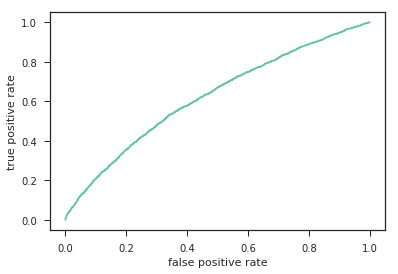

In [16]:
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression

config = [
    {
        "field": "Income",
        "transformers": [
            {"name": "dummyizer"}
        ]
    },
    {
        "field": "Firstdate",
        "transformers": [
            {"name": "range_numeric"}
        ]
    },
    {
        "field": "Lastdate",
        "transformers": [
            {"name": "range_numeric"}
        ]
    },
    {
        "field": "Amount",
        "transformers": [
            {"name": "standard_numeric"},
            {
                "name": "quantile_numeric",
                "config": {"n_quantiles": 10}
            }
        ]
    },
    {
        "field": "rfaa2",
        "transformers": [
            {"name": "dummyizer"}
        ]
    },
    {
        "field": "rfaf2",
        "transformers": [
            {"name": "dummyizer"}
        ]
    },
    {
        "field": "pepstrfl",
        "transformers": [
            {"name": "dummyizer"}
        ]
    },
    {
        "field": "glast",
        "transformers": [
            {"name": "standard_numeric"},
            {
                "name": "quantile_numeric",
                "config": {"n_quantiles": 10}
            }
        ]
    },
    {
        "field": "gavr",
        "transformers": [
            {"name": "standard_numeric"},
            {
                "name": "quantile_numeric",
                "config": {"n_quantiles": 10}
            }
        ]
    }
]

pipeline = pipeline_from_config(config)
X_train = pipeline.fit_transform(train_df)
X_test = pipeline.transform(test_df)

model = LogisticRegression()
model.fit(X_train, y_train)

predictions = model.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, predictions)

plt.plot(fpr, tpr)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.show()